In [12]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
import pandas as pd
import geopandas 
import matplotlib.pyplot as plt

TypeError: 'bytes' object cannot be interpreted as an integer

### Creation of the Session

In [10]:
spark = SparkSession \
    .builder \
    .master('spark://anthony-Latitude-3510:7077') \
    .appName("1") \
    .getOrCreate()

NameError: name 'SparkSession' is not defined

### One file reading for all the work

In [14]:
path = "Assignment/data/data.24h.json"
sensorsDF = spark.read.json(path)

### Design of the initial dataframe 

In [15]:
sensorsDF.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- id: long (nullable = true)
 |-- location: struct (nullable = true)
 |    |-- altitude: string (nullable = true)
 |    |-- country: string (nullable = true)
 |    |-- exact_location: long (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- indoor: long (nullable = true)
 |    |-- latitude: string (nullable = true)
 |    |-- longitude: string (nullable = true)
 |-- sampling_rate: long (nullable = true)
 |-- sensor: struct (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- pin: string (nullable = true)
 |    |-- sensor_type: struct (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- manufacturer: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |-- sensordatavalues: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- value: string (nullable = true)
 |    |    |-- value_type: string (nu

In [16]:
sensorsDF.createOrReplaceTempView("sensors")

In [17]:
# Collection  of the elements
sensorsDF = spark.sql("SELECT location.country, DOUBLE(location.latitude), DOUBLE(location.longitude), CAST(timestamp AS DATE), DOUBLE(sensordatavalues.value[0]), DOUBLE(sensordatavalues.value[1]) FROM sensors WHERE sensordatavalues.value_type[0]='P1' AND sensordatavalues.value_type[1]='P2' ")
sensorsDF.collect()

# Header renqming
sensorsDF = sensorsDF.withColumnRenamed("sensordatavalues.value[0]", "P1")
sensorsDF = sensorsDF.withColumnRenamed("sensordatavalues.value[1]", "P2")
sensorsDF = sensorsDF.withColumnRenamed("location.latitude", "latitude")
sensorsDF = sensorsDF.withColumnRenamed("location.longitude", "longitude")
sensorsDF = sensorsDF.withColumnRenamed("timestamp", "date")

# removing identical lines  due to the dataset errors
sensorsDF = sensorsDF.distinct()
sensorsDF.show()

+-------+--------------+--------------+----------+------+------+
|country|      latitude|     longitude|      date|    P1|    P2|
+-------+--------------+--------------+----------+------+------+
|     DE|        51.634|         7.112|2022-11-05| 22.41| 10.94|
|     DE|        52.408|         13.06|2022-11-05|  0.67|  0.58|
|     DE|        51.716|         8.748|2022-11-05|371.37| 73.31|
|     DE|        48.154|        11.536|2022-11-04|  3.22|  2.11|
|     DE|         48.55|         8.822|2022-11-05|  2.97|   1.4|
|     DE|         48.73|         9.114|2022-11-05|  6.01|  4.78|
|     DE|        48.518|          9.05|2022-11-05|  5.55|  4.09|
|     DE|        53.882|        10.642|2022-11-05|  0.28|  0.28|
|     BE|        50.932|         3.142|2022-11-05|  8.42|  5.87|
|     DE|        53.686|         9.158|2022-11-05|  8.47|  2.04|
|     DE|        53.582|         9.712|2022-11-05|   3.3|  2.02|
|     BE|        50.892|         3.992|2022-11-05| 13.44|  6.99|
|     DE|        54.456| 

In [18]:
sensorsDF = sensorsDF.withColumn('AQI1', 
                                 F.when((sensorsDF.P1 <= 16),1).
                                 when((sensorsDF.P1 < 33),2).
                                 when((sensorsDF.P1 < 50),3).
                                 when((sensorsDF.P1 < 58),4).
                                 when((sensorsDF.P1 < 66),5).
                                 when((sensorsDF.P1 < 75),6).
                                 when((sensorsDF.P1 < 83),7).
                                 when((sensorsDF.P1 < 91),8).
                                 when((sensorsDF.P1 < 100),9).
                                 when((sensorsDF.P1 > 100),10))

sensorsDF = sensorsDF.withColumn('AQI2', 
                                 F.when((sensorsDF.P2 <= 11),1).
                                 when((sensorsDF.P2 < 23),2).
                                 when((sensorsDF.P2 < 35),3).
                                 when((sensorsDF.P2 < 41),4).
                                 when((sensorsDF.P2 < 47),5).
                                 when((sensorsDF.P2 < 53),6).
                                 when((sensorsDF.P2 < 58),7).
                                 when((sensorsDF.P2 < 64),8).
                                 when((sensorsDF.P2 < 70),9).
                                 when((sensorsDF.P2 > 70),10))

sensorsDF = sensorsDF.withColumn('AQI', 
                                 F.when((sensorsDF.AQI1 <= sensorsDF.AQI2),sensorsDF.AQI2).
                                 otherwise(sensorsDF.AQI1))
sensorsDF = sensorsDF.drop("AQI1", "AQI2", "P1", "P2") 

In [19]:
sensorsDF.show()

+-------+----------+----------+----------+---+
|country|  latitude| longitude|      date|AQI|
+-------+----------+----------+----------+---+
|     DE|    50.656|     7.568|2022-11-02|  2|
|     BG|    42.664|    23.346|2022-11-02|  2|
|     DE|     53.33|     9.876|2022-11-02|  1|
|     DE|    51.454|    12.616|2022-11-02|  1|
|     BG|    42.562|    27.636|2022-11-02|  3|
|     DE|    52.464|     13.48|2022-11-02|  1|
|     BG|    41.574|    23.734|2022-11-02|  1|
|     DE|    51.386|     6.778|2022-11-02|  1|
|     DE|    53.546|    10.104|2022-11-02|  1|
|     DE|    51.274|     7.128|2022-11-02|  1|
|     DE|    50.866|     6.744|2022-11-02|  1|
|     DE|     48.52|    11.228|2022-11-02|  1|
|     PL|      51.1|    17.068|2022-11-02| 10|
|     DE|    49.436|      8.49|2022-11-02|  1|
|     NO|63.4210042|10.4253665|2022-11-02|  1|
|     DE|     49.69|     6.472|2022-11-02|  1|
|     NL|     52.26|      6.03|2022-11-02|  1|
|     DE|    50.158|     8.626|2022-11-02|  1|
|     DE|    

# 1. Top 10 countries of average air quality improvement over the previous 24h 

### Computing of the average AQI per country and day 

In [20]:
sensorsDF2 = sensorsDF.groupBy("country","date") \
                      .agg(F.avg("AQI")) \
                      .orderBy("date") 

In [21]:
sensorsDF2.show()

+-------+----------+------------------+
|country|      date|          avg(AQI)|
+-------+----------+------------------+
|     DE|2022-11-01| 1.288888888888889|
|     NL|2022-11-01|               1.0|
|     BG|2022-11-01|             2.375|
|     RS|2022-11-01| 6.666666666666667|
|     PL|2022-11-01|               3.5|
|     RU|2022-11-01|              1.25|
|     MK|2022-11-01|              10.0|
|     VN|2022-11-01|               1.0|
|     IT|2022-11-01|2.4545454545454546|
|     AT|2022-11-01|1.6666666666666667|
|     GB|2022-11-01|               1.4|
|     HU|2022-11-01|2.8333333333333335|
|     CZ|2022-11-01|               6.5|
|     UK|2022-11-01|               1.0|
|     ES|2022-11-01|              10.0|
|     FR|2022-11-01|               1.2|
|     AU|2022-11-01|               1.0|
|     IE|2022-11-01|               5.0|
|     NZ|2022-11-01|               1.0|
|     RO|2022-11-01|               2.0|
+-------+----------+------------------+
only showing top 20 rows



In [22]:
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

DfPlotAverage = sensorsDF2.filter(F.col("date") == "2022-11-02") # Replace by current_date() 

m = folium.Map(zoom_start=15)

m

In [23]:
sensorsDF2 = sensorsDF2.filter((F.col("date") == "2022-11-02") | (F.col("date") == "2022-11-03")) \
                       .withColumn("avg(AQI)", F.when((F.col("date") == "2022-11-03"), - sensorsDF2["avg(AQI)"]).otherwise(sensorsDF2["avg(AQI)"])) \
                       .groupBy("country") \
                       .agg(F.sum("avg(AQI)")) \
                       .orderBy(F.col("sum(avg(AQI))").desc()) 

In [24]:
sensorsDF2.show()

+-------+-------------------+
|country|      sum(avg(AQI))|
+-------+-------------------+
|     ID|                5.0|
|     TR|               3.75|
|     PL| 1.2731143103236127|
|     KG|              1.125|
|     LV| 1.0869565217391304|
|     ME|                1.0|
|     SA|                1.0|
|     CZ| 0.8667690956979803|
|     IN|                0.5|
|     CN|                0.5|
|     LT|                0.5|
|     HR|                0.5|
|     BA|0.45833333333333304|
|     AL| 0.3472222222222223|
|     HU|0.34536891679748827|
|     MD| 0.3333333333333335|
|     IS| 0.3333333333333335|
|     EE|0.33333333333333326|
|     AT| 0.3284878863826233|
|     MX| 0.2941176470588234|
+-------+-------------------+
only showing top 20 rows



# 2. Top 50 regions of average air quality improvement over the previous 24h

In [25]:
sensorsDF2 = sensorsDF

## Clustering 

### Dataset dedicate to the clustering 

In [26]:
sensorsDF2.count()

63624

In [27]:
trainingData = sensorsDF2.dropDuplicates(['latitude', 'longitude'])
trainingData.count()

12871

In [1]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler().setInputCols(['latitude','longitude']).setOutputCol("GeocCoordinates")

trainingData = assembler.transform(trainingData)

TypeError: 'bytes' object cannot be interpreted as an integer

In [157]:
trainingData.show()

+-------+---------------+---------------+----------+-----+----+---+--------------------+
|country|       latitude|      longitude|      date|   P1|  P2|AQI|     GeocCoordinates|
+-------+---------------+---------------+----------+-----+----+---+--------------------+
|     NZ|        -46.434|        168.382|2022-11-04| 4.35|0.94|  1|   [-46.434,168.382]|
|     NZ|        -43.152|        172.732|2022-11-04| 2.24|1.38|  1|   [-43.152,172.732]|
|     AR|         -37.98|        -63.602|2022-11-02| 4.14|1.35|  1|    [-37.98,-63.602]|
|     AU|         -37.95|        145.008|2022-11-06| 3.36|3.25|  1|    [-37.95,145.008]|
|     NZ|        -37.794|        175.246|2022-11-02| 5.51|1.09|  1|   [-37.794,175.246]|
|     AR|         -37.67|        -63.532|2022-11-04|21.83|3.85|  2|    [-37.67,-63.532]|
|     AR|      -37.38167|     -64.603843|2022-11-06| 4.95|1.67|  1|[-37.38167,-64.60...|
|     NZ|        -36.854|         174.87|2022-11-02| 0.64|0.64|  1|    [-36.854,174.87]|
|     AR| -36.6479175

### Elbow method

Text(0, 0.5, 'Cost')

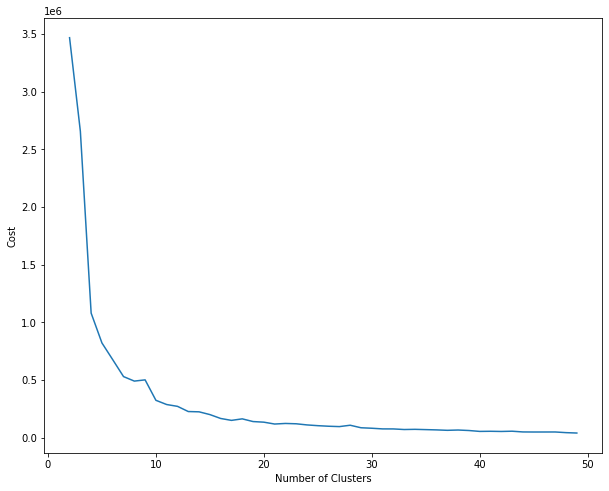

In [ ]:
from pyspark.ml.clustering import KMeans, KMeansModel
cost=[]
for k in range(2,50):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('GeocCoordinates')
    model = kmeans.fit(trainingData)
    cost.append(model.summary.trainingCost)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,50),cost)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Cost')

Text(0, 0.5, 'Cost')

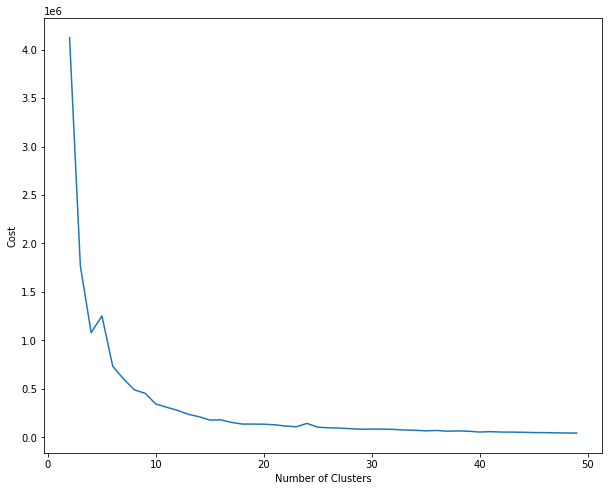

In [111]:
cost=[]
for k in range(2,50):
    kmeans = KMeans().setK(k).setSeed(100).setFeaturesCol('GeocCoordinates')
    model = kmeans.fit(trainingData)
    cost.append(model.summary.trainingCost)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,50),cost)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Cost')

### K-mean model computing 

In [158]:
from pyspark.ml.clustering import KMeans, KMeansModel

kmeans = KMeans() \
          .setK(200) \
          .setFeaturesCol("GeocCoordinates")\
          .setPredictionCol("cluster") \
            


model = kmeans.fit(trainingData)

In [159]:
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

# Create a map
m = folium.Map(tiles='cartodbpositron', zoom_start=13)
# Add points to the map
for array in model.clusterCenters():
    Marker([array[0], array[1]]).add_to(m)

# Display the map
m

## Use K-Means model

In [160]:
# Add feature column to dataset
sensorsDF2 = assembler.transform(sensorsDF2)
# Apply model 
sensorsDF2 = model.transform(sensorsDF2)
sensorsDF2.show()

+-------+----------+----------+----------+------+-----+---+--------------------+-------+
|country|  latitude| longitude|      date|    P1|   P2|AQI|     GeocCoordinates|cluster|
+-------+----------+----------+----------+------+-----+---+--------------------+-------+
|     DE|    50.656|     7.568|2022-11-02| 18.98| 2.93|  2|      [50.656,7.568]|    184|
|     BG|    42.664|    23.346|2022-11-02| 21.78|11.87|  2|     [42.664,23.346]|    113|
|     DE|     53.33|     9.876|2022-11-02|  15.4| 5.98|  1|       [53.33,9.876]|     35|
|     DE|    51.454|    12.616|2022-11-02|  6.95| 2.84|  1|     [51.454,12.616]|    178|
|     BG|    42.562|    27.636|2022-11-02| 45.24|17.17|  3|     [42.562,27.636]|     74|
|     DE|    52.464|     13.48|2022-11-02|  9.84| 4.58|  1|      [52.464,13.48]|     56|
|     BG|    41.574|    23.734|2022-11-02|  1.12| 0.57|  1|     [41.574,23.734]|     87|
|     DE|    51.386|     6.778|2022-11-02|  6.06| 3.08|  1|      [51.386,6.778]|     31|
|     DE|    53.546| 

In [161]:
sensorsDF2 = sensorsDF2.groupBy("cluster","date") \
                      .agg(F.avg("AQI")) \
                      .orderBy("date") 

In [162]:
sensorsDF2.show()

+-------+----------+------------------+
|cluster|      date|          avg(AQI)|
+-------+----------+------------------+
|     61|2022-11-01|               1.0|
|    138|2022-11-01|               4.0|
|    134|2022-11-01|               1.0|
|    193|2022-11-01|               1.0|
|    113|2022-11-01|1.3333333333333333|
|     75|2022-11-01|               1.0|
|    189|2022-11-01|               1.5|
|     47|2022-11-01|               1.0|
|     77|2022-11-01|               1.0|
|     74|2022-11-01|              10.0|
|    173|2022-11-01|               1.0|
|    135|2022-11-01|               1.0|
|     62|2022-11-01|               1.0|
|    199|2022-11-01|               3.0|
|    158|2022-11-01|               1.0|
|     93|2022-11-01|               1.0|
|     94|2022-11-01|               1.0|
|     15|2022-11-01|               1.0|
|    129|2022-11-01|               1.0|
|     24|2022-11-01|               1.0|
+-------+----------+------------------+
only showing top 20 rows



In [163]:
sensorsDF2 = sensorsDF2.filter((F.col("date") == "2022-11-02") | (F.col("date") == "2022-11-03")) \
                       .withColumn("avg(AQI)", F.when((F.col("date") == "2022-11-03"), - sensorsDF2["avg(AQI)"]).otherwise(sensorsDF2["avg(AQI)"])) \
                       .groupBy("cluster") \
                       .agg(F.sum("avg(AQI)")) \
                       .orderBy(F.col("sum(avg(AQI))").desc()) 

In [164]:
sensorsDF2.show()

+-------+------------------+
|cluster|     sum(avg(AQI))|
+-------+------------------+
|    114|              3.75|
|     79|               2.5|
|    101|2.4365079365079367|
|      3|2.3434464259823113|
|     95| 2.185531914893617|
|    116|1.6431159420289854|
|    199|1.2131147540983607|
|    172|               1.0|
|     63|               1.0|
|     13|               1.0|
|    169|               1.0|
|    141|               1.0|
|    120|               1.0|
|    126|0.9555061179087878|
|     80|             0.875|
|     68|0.8664772727272727|
|     10|0.7999999999999998|
|     64|0.7894736842105263|
|    170|0.7306501547987616|
|    142| 0.666666666666667|
+-------+------------------+
only showing top 20 rows



# 3. Longest streaks of good air quality 


In [21]:
sensorsDF3 = sensorsDF

In [22]:
sensorsDF3 = sensorsDF3.groupBy("country","date") \
                       .agg(F.avg("AQI")) \
                       .orderBy("country", "date") \
                       .withColumn("LowIndex", F.when(F.col("avg(AQI)") <= 3, 1).otherwise(0))

In [23]:
sensorsDF3.show()

+-------+----------+------------------+--------+
|country|      date|          avg(AQI)|LowIndex|
+-------+----------+------------------+--------+
|     AD|2022-11-02|               1.0|       1|
|     AD|2022-11-03|               1.0|       1|
|     AD|2022-11-04|               1.0|       1|
|     AD|2022-11-05|               1.0|       1|
|     AD|2022-11-06|               1.0|       1|
|     AL|2022-11-02| 5.222222222222222|       0|
|     AL|2022-11-03|             4.875|       0|
|     AL|2022-11-04| 4.857142857142857|       0|
|     AL|2022-11-05|2.5714285714285716|       1|
|     AL|2022-11-06|2.4285714285714284|       1|
|     AR|2022-11-02|1.7333333333333334|       1|
|     AR|2022-11-03|1.9333333333333333|       1|
|     AR|2022-11-04|2.3333333333333335|       1|
|     AR|2022-11-05| 2.066666666666667|       1|
|     AR|2022-11-06|1.6666666666666667|       1|
|     AT|2022-11-01|1.6666666666666667|       1|
|     AT|2022-11-02|1.6793650793650794|       1|
|     AT|2022-11-03|

In [24]:
from pyspark.sql import Window 
from pyspark.sql import functions as f

w1 = Window.partitionBy(sensorsDF3.country).orderBy(sensorsDF3.date)
w2 = Window.partitionBy(sensorsDF3.country,sensorsDF3.LowIndex).orderBy(sensorsDF3.date)

res = sensorsDF3.withColumn('grp',f.row_number().over(w1)-f.row_number().over(w2))

res.show()

+-------+----------+------------------+--------+---+
|country|      date|          avg(AQI)|LowIndex|grp|
+-------+----------+------------------+--------+---+
|     AD|2022-11-02|               1.0|       1|  0|
|     AD|2022-11-03|               1.0|       1|  0|
|     AD|2022-11-04|               1.0|       1|  0|
|     AD|2022-11-05|               1.0|       1|  0|
|     AD|2022-11-06|               1.0|       1|  0|
|     AL|2022-11-02| 5.222222222222222|       0|  0|
|     AL|2022-11-03|             4.875|       0|  0|
|     AL|2022-11-04| 4.857142857142857|       0|  0|
|     AL|2022-11-05|2.5714285714285716|       1|  3|
|     AL|2022-11-06|2.4285714285714284|       1|  3|
|     AR|2022-11-02|1.7333333333333334|       1|  0|
|     AR|2022-11-03|1.9333333333333333|       1|  0|
|     AR|2022-11-04|2.3333333333333335|       1|  0|
|     AR|2022-11-05| 2.066666666666667|       1|  0|
|     AR|2022-11-06|1.6666666666666667|       1|  0|
|     AT|2022-11-01|1.6666666666666667|       

In [25]:
from pyspark.sql import Window 
from pyspark.sql import functions as f
#Windows definition
w1 = Window.partitionBy(sensorsDF3.country).orderBy(sensorsDF3.date)
w2 = Window.partitionBy(sensorsDF3.country,sensorsDF3.LowIndex).orderBy(sensorsDF3.date)

res = sensorsDF3.withColumn('grp',f.row_number().over(w1)-f.row_number().over(w2))
#Window definition for streak
w3 = Window.partitionBy(res.country,res.LowIndex,res.grp).orderBy(res.date)
sensorsDF3 = res.withColumn('streak_0',f.when(res.LowIndex == 1,0).otherwise(f.row_number().over(w3))) \
                .withColumn('streak_1',f.when(res.LowIndex == 0,0).otherwise(f.row_number().over(w3)))
sensorsDF3.show()

+-------+----------+------------------+--------+---+--------+--------+
|country|      date|          avg(AQI)|LowIndex|grp|streak_0|streak_1|
+-------+----------+------------------+--------+---+--------+--------+
|     AD|2022-11-02|               1.0|       1|  0|       0|       1|
|     AD|2022-11-03|               1.0|       1|  0|       0|       2|
|     AD|2022-11-04|               1.0|       1|  0|       0|       3|
|     AD|2022-11-05|               1.0|       1|  0|       0|       4|
|     AD|2022-11-06|               1.0|       1|  0|       0|       5|
|     AL|2022-11-02| 5.222222222222222|       0|  0|       1|       0|
|     AL|2022-11-03|             4.875|       0|  0|       2|       0|
|     AL|2022-11-04| 4.857142857142857|       0|  0|       3|       0|
|     AL|2022-11-05|2.5714285714285716|       1|  3|       0|       1|
|     AL|2022-11-06|2.4285714285714284|       1|  3|       0|       2|
|     AR|2022-11-02|1.7333333333333334|       1|  0|       0|       1|
|     

In [26]:
sensorsDF3 = sensorsDF3.groupBy("country") \
                       .agg(F.max("streak_1"))

In [27]:
sensorsDF3.show()

+-------+-------------+
|country|max(streak_1)|
+-------+-------------+
|     AD|            5|
|     AL|            2|
|     AR|            5|
|     AT|            6|
|     AU|            6|
|     AX|            5|
|     AZ|            5|
|     BA|            2|
|     BE|            6|
|     BG|            6|
|     BJ|            5|
|     BR|            5|
|     BY|            5|
|     CA|            5|
|     CD|            5|
|     CH|            5|
|     CL|            5|
|     CN|            1|
|     CO|            5|
|     CY|            5|
+-------+-------------+
only showing top 20 rows

